### LoRA Fine-Tuning with MLX LM

In this notebook, we'll walk through how to [LoRA fine-tune](https://arxiv.org/abs/2106.09685) an LLM with MLX LM. We'll use the [HellaSwag](https://rowanzellers.com/hellaswag/) dataset for common sense reasoning as an example. An outline:

1. Download the dataset and prepare it in the right format for MLX LM.
2. Setup and run LoRA training. We'll show how to capture the training logs and plot some statistics to visualize the performance.
3. Evaluate on the test set. We'll compute the final question-answer accuracy of the fine-tuned model.
4. Fuse the resulting adapters into the base model and upload to Hugging Face.
5. Discuss tips for debugging accuracy and efficiency.

### Install dependencies

Run:

```bash
CONDA_SUBDIR=osx-arm64 conda create -n fine-tune-llm python=3.11
conda activate fine-tune-llm
conda config --env --set subdir osx-arm64
````

Then:

```bash
pip install -r requirements.txt
````

In [15]:
import matplotlib.pyplot as plt
import mlx.core as mx
import mlx.optimizers as optim
from mlx.utils import tree_flatten
from mlx_lm import load, generate
from mlx_lm.tuner import train, evaluate, TrainingArgs
from mlx_lm.tuner import linear_to_lora_layers
import json
import random
from pathlib import Path
from datasets import load_dataset
import os
from dotenv import load_dotenv
from textwrap import fill
import requests
from tqdm import tqdm
import numpy as np
from time import sleep
import re
from sklearn.metrics import accuracy_score
from huggingface_hub import HfApi

# Try to import evaluation libraries (will install if needed later)
try:
    from evaluate import load as load_metric
except ImportError:
    print("Note: 'evaluate' library not installed. Will install if BERTScore evaluation is used.")
    load_metric = None

load_dotenv()

True

In [17]:
# Helper functions with error handling

def safe_generate(model, tokenizer, prompt, max_tokens=200, temperature=0.7):
    """Generate text with error handling"""
    try:
        return generate(model, tokenizer, prompt, max_tokens=max_tokens, temp=temperature)
    except Exception as e:
        print(f"Generation error: {e}")
        return ""

def validate_data_format(data_list):
    """Validate that data is in the correct Phi-3 format"""
    errors = []
    required_tokens = ["<|system|>", "<|user|>", "<|assistant|>", "<|end|>"]
    
    for i, item in enumerate(data_list):
        if not isinstance(item, str):
            errors.append(f"Item {i} is not a string: {type(item)}")
            continue
            
        # Check for all required tokens
        for token in required_tokens:
            if token not in item:
                errors.append(f"Item {i} missing required token: {token}")
        
        # Check token order
        if "<|system|>" in item and "<|user|>" in item:
            if item.index("<|system|>") > item.index("<|user|>"):
                errors.append(f"Item {i} has incorrect token order (system should come before user)")
    
    if errors:
        print(f"⚠️  Data validation found {len(errors)} issues:")
        for error in errors[:5]:  # Show first 5 errors
            print(f"  - {error}")
        if len(errors) > 5:
            print(f"  ... and {len(errors) - 5} more")
        return False
    print("✅ Data validation passed - correct Phi-3 format")
    return True

def print_training_summary(model, config, train_size, val_size, test_size):
    """Print a summary of training configuration"""
    num_params = sum(v.size for _, v in tree_flatten(model.trainable_parameters()))
    total_params = sum(v.size for _, v in tree_flatten(model.parameters()))
    
    print("="*60)
    print("TRAINING CONFIGURATION SUMMARY")
    print("="*60)
    print(f"\n📊 Dataset:")
    print(f"  Training samples:   {train_size}")
    print(f"  Validation samples: {val_size}")
    print(f"  Test samples:       {test_size}")
    
    print(f"\n🔧 LoRA Configuration:")
    print(f"  Layers to adapt:    {config['lora_layers']}/{config['num_layers']}")
    print(f"  LoRA rank:          {config['lora_parameters']['rank']}")
    print(f"  LoRA scale:         {config['lora_parameters']['scale']}")
    print(f"  Dropout:            {config['lora_parameters']['dropout']}")
    
    print(f"\n📈 Model Parameters:")
    print(f"  Trainable:          {num_params:,} ({num_params/total_params*100:.2f}%)")
    print(f"  Total:              {total_params:,}")
    print("="*60 + "\n")

### Pull dataset from Hugging Face

In [18]:
# Load the dataset from Hugging Face
dataset = load_dataset("didierlopes/my-blog-qa-dataset")

# Print some information about the dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'conversation', 'context', 'url', 'date'],
        num_rows: 91
    })
})

### Ensure that the dataset is split into train, validation and test

Since this dataset only has train examples, we need to separate some of these blog posts for testing so we can assess whether fine-tuning accuracy is improving.

Put the data splits in the MLX LM training format.

The format simply expects the data to be in a container which supports random access to the individual examples (e.g. a Python `list`):
```
["An example for the model.", "Another example for the model.", ...]
```

For more details, see the [documentation on supported formats](https://github.com/ml-explore/mlx-examples/blob/main/llms/mlx_lm/LORA.md#Data).

In [20]:
# Get the train dataset
all_data = dataset['train']

# Convert to list of dictionaries
data_list = all_data.to_list()

# Define test_size and val_size
test_size = 0.1  # 10% of training samples
val_size = 0.2   # 20% of training samples

# Initialize train, validation and test sets
train_set = []
val_set = []
test_set = []

# System prompt for consistency
# This is required for Instruct models to work properly, but not for base models
SYSTEM_PROMPT = "You are Didier, CEO of OpenBB. You write with clarity and impact, focusing on fintech, open source, AI, and the future of research workflows."

for sample in data_list:
    conversation = sample["conversation"]
    conversation_samples = []

    for i in range(0, len(conversation), 2):
        user_message = conversation[i]
        assistant_message = conversation[i+1] if i+1 < len(conversation) else None
        
        if assistant_message:
            question = user_message["content"]
            answer = assistant_message["content"]
            
            # Use proper Phi-3 format with system prompt
            # from here https://huggingface.co/microsoft/Phi-3-mini-4k-instruct
            formatted_sample = (
                f"<|system|>\n{SYSTEM_PROMPT}<|end|>\n"
                f"<|user|>\n{question}<|end|>\n"
                f"<|assistant|>\n{answer}<|end|>"
            )
            conversation_samples.append(formatted_sample)

    # Shuffle the conversation samples randomly
    # Assumes that the order is not important
    random.shuffle(conversation_samples)

    # Calculate split indices for this conversation
    total_size = len(conversation_samples)
    test_idx = int(total_size * (1 - test_size))
    val_idx = int(test_idx * (1 - val_size))

    # Split the separated conversation samples
    train_set.extend(conversation_samples[:val_idx])
    val_set.extend(conversation_samples[val_idx:test_idx])
    test_set.extend(conversation_samples[test_idx:])

print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

# Show a sample to verify format
print("\n📝 Sample formatted data:")
print(train_set[0][:200] + "...")

Train set size: 1466
Validation set size: 408
Test set size: 255

📝 Sample formatted data:
<|system|>
You are Didier, CEO of OpenBB. You write with clarity and impact, focusing on fintech, open source, AI, and the future of research workflows.<|end|>
<|user|>
Are there any notable partners ...


#### Alternative: Using the Tokenizer's Chat Template

For production use, you can also use the tokenizer's built-in chat template:

```python
# Example using tokenizer.apply_chat_template()
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Why is OpenBB special?"},
    {"role": "assistant", "content": "OpenBB is special because..."}
]

# This would format it correctly for Phi-3
# formatted = tokenizer.apply_chat_template(messages, tokenize=False)
```

However, for fine-tuning with MLX LM, the explicit format shown above works reliably.

In [21]:
# Validate the data format
print("Validating training data...")
validate_data_format(train_set[:10])  # Check first 10 samples

print("\nValidating validation data...")
validate_data_format(val_set[:10])

print("\nValidating test data...")
validate_data_format(test_set[:10])

Validating training data...
✅ Data validation passed - correct Phi-3 format

Validating validation data...
✅ Data validation passed - correct Phi-3 format

Validating test data...
✅ Data validation passed - correct Phi-3 format


True

In [22]:
conversation_samples[:5]

['<|system|>\nYou are Didier, CEO of OpenBB. You write with clarity and impact, focusing on fintech, open source, AI, and the future of research workflows.<|end|>\n<|user|>\nWhat kind of support or resources do you envision providing to users as they get started with Gamestonk Terminal?<|end|>\n<|assistant|>\nWe will provide extensive documentation, tutorials, and a community forum for users to ask questions, share knowledge, and collaborate on the project. Additionally, we will offer regular updates, bug fixes, and new feature releases through our GitHub repository. This open-source nature allows us to rely on user contributions and feedback to drive the development of Gamestonk Terminal.<|end|>',
 "<|system|>\nYou are Didier, CEO of OpenBB. You write with clarity and impact, focusing on fintech, open source, AI, and the future of research workflows.<|end|>\n<|user|>\nWhat innovative features do you think will set Gamestonk Terminal apart from other financial analysis tools in the fut

### Fine tune

For fine-tuning, we'll use Microsoft's [Phi-3 mini](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct).

At 3.8 billion parameters, Phi-3 mini is a high-quality model that is also fast to fine-tune on most Apple silicon machines.

Setup the LoRA parameters and make the training arguments.

See the [training argument class](https://github.com/ml-explore/mlx-examples/blob/81318ad4a8b2ca5fd1431a42db2b0244d16be851/llms/mlx_lm/tuner/trainer.py#L31-L63) for a more detailed list of training parameters. 

Recall the LoRA update is $W^\top \mathbf{x} + c \cdot \mathbf{a} \mathbf{b}^\top \mathbf{x}$ where $\mathbf{a}$ has shape `(D, rank)`.

With that in mind, the LoRA parameters to attend to are:
- `lora_layers`: The number of Transformer blocks from the top of the model to adapt.
- `rank`: The rank of the low-rank adapters. A larger rank implies more adapter parameters per linear layer.
- `scale`: This is the constant $c$ that scales the low-rank update.

In [ ]:
# Make a directory to save the adapter config and weights
adapter_path = Path("adapters")
adapter_path.mkdir(parents=True, exist_ok=True)

# Enhanced LoRA configuration based on best practices
lora_config = {
    "num_layers": 32,
    "lora_layers": 32,  # Use all layers for better fine-tuning (was 8)
    "lora_parameters": {
        "rank": 16,  # Increased rank for more expressive power (was 8)
        "scale": 20.0,  # Higher scale based on MLX best practices (was 5.0)
        "dropout": 0.1,  # Reduced dropout for better learning (was 0.2)
        # Optionally adapt more layers for Phi-3
        # "keys": ["self_attn.q_proj", "self_attn.k_proj", 
        #          "self_attn.v_proj", "self_attn.o_proj"]
    }
}

# Save the LoRA config to the adapter path
with open(adapter_path / "adapter_config.json", "w") as fid:
    json.dump(lora_config, fid, indent=4)    

# Try to add batch_size to TrainingArgs - it might be supported
training_args = TrainingArgs(
    adapter_file=adapter_path / "adapters.safetensors",
    iters=1000,  # Increased iterations (was 500)
    steps_per_eval=50,  # More frequent evaluation (was 100)
    batch_size=8,  # Try adding batch_size here
)

Next, load the Phi-3 mini model. Note this may take a few minutes to download from HuggingFace if you haven't downloaded it before.

In [26]:
base_model_path = "microsoft/Phi-3-mini-4k-instruct"
# base_model_path = "mistralai/Mistral-7B-v0.1"
# base_model_path = "mlx-community/DeepSeek-R1-Distill-Qwen-7B-abliterated-4bit" #"deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
model, tokenizer = load(base_model_path)

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 194042.53it/s]


After loading the model, freeze it's parameters so we don't train them.

In [27]:
model.freeze()

Model(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072)
    (layers.0): TransformerBlock(
      (self_attn): Attention(
        (qkv_proj): Linear(input_dims=3072, output_dims=9216, bias=False)
        (o_proj): Linear(input_dims=3072, output_dims=3072, bias=False)
        (rope): RoPE(96, traditional=False)
      )
      (mlp): MLP(
        (gate_up_proj): Linear(input_dims=3072, output_dims=16384, bias=False)
        (down_proj): Linear(input_dims=8192, output_dims=3072, bias=False)
      )
      (input_layernorm): RMSNorm(3072, eps=1e-05)
      (post_attention_layernorm): RMSNorm(3072, eps=1e-05)
    )
    (layers.1): TransformerBlock(
      (self_attn): Attention(
        (qkv_proj): Linear(input_dims=3072, output_dims=9216, bias=False)
        (o_proj): Linear(input_dims=3072, output_dims=3072, bias=False)
        (rope): RoPE(96, traditional=False)
      )
      (mlp): MLP(
        (gate_up_proj): Linear(input_dims=3072, output_dims=16384, bias=False)
        (dow

Then convert linear layers to LoRA layers using the MLX LM utility `linear_to_lora_layers`.
 
The adapters in the `LoRA` layers are not frozen, so they will be included in the model's `trainable_parameters`.
 
Check-out the [LoRA layer implementation](https://github.com/ml-explore/mlx-examples/blob/81318ad4a8b2ca5fd1431a42db2b0244d16be851/llms/mlx_lm/tuner/lora.py#L72-L104) to see how it all works.

By default, MLX LM only adapts the query, key, and value projection matrices for Phi-3.

You can specify the layers to adapt by setting `lora_parameters["keys"]` to a list of layer names. In this case it defaults to `["attn.qkv_proj"]`. 

In [28]:
linear_to_lora_layers(
    model,
    lora_config["lora_layers"],
    lora_config["lora_parameters"]
)

num_train_params = (
    sum(v.size for _, v in tree_flatten(model.trainable_parameters()))
)
print(f"Number of trainable parameters: {num_train_params}")

Number of trainable parameters: 6291456


In [29]:
# Print training configuration summary
print_training_summary(model, lora_config, len(train_set), len(val_set), len(test_set))

TRAINING CONFIGURATION SUMMARY

📊 Dataset:
  Training samples:   1466
  Validation samples: 408
  Test samples:       255

🔧 LoRA Configuration:
  Layers to adapt:    32/32
  LoRA rank:          16
  LoRA scale:         20.0
  Dropout:            0.1

📈 Model Parameters:
  Trainable:          6,291,456 (0.16%)
  Total:              3,827,371,008



Let's put the model in training mode, which enables specific behaviors needed during training like dropout (randomly deactivating neurons to prevent overfitting) and batch normalization (computing statistics from the current batch).

This differs from evaluation mode (`model.eval()`), where these features behave differently to ensure consistent inference results.

In [34]:
model.train()

Model(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072)
    (layers.0): TransformerBlock(
      (self_attn): Attention(
        (qkv_proj): LoRALinear(
          (linear): Linear(input_dims=3072, output_dims=9216, bias=False)
          (dropout): Dropout(p=0.09999999999999998)
        )
        (o_proj): Linear(input_dims=3072, output_dims=3072, bias=False)
        (rope): RoPE(96, traditional=False)
      )
      (mlp): MLP(
        (gate_up_proj): Linear(input_dims=3072, output_dims=16384, bias=False)
        (down_proj): Linear(input_dims=8192, output_dims=3072, bias=False)
      )
      (input_layernorm): RMSNorm(3072, eps=1e-05)
      (post_attention_layernorm): RMSNorm(3072, eps=1e-05)
    )
    (layers.1): TransformerBlock(
      (self_attn): Attention(
        (qkv_proj): LoRALinear(
          (linear): Linear(input_dims=3072, output_dims=9216, bias=False)
          (dropout): Dropout(p=0.09999999999999998)
        )
        (o_proj): Linear(input_dims=3072, out

Let's use `Adam` for the optimizer, but you can specify any [optimizer](https://ml-explore.github.io/mlx/build/html/python/optimizers/common_optimizers.html) with any [scheduler](https://ml-explore.github.io/mlx/build/html/python/optimizers/schedulers.html).


In [31]:
# Use Adam optimizer with optimized learning rate
# Note: MLX doesn't support gradient accumulation or lr scheduling in TrainingArgs
# For effective batch size of 16, we reduced batch_size to 8 (hardware permitting)
opt = optim.Adam(learning_rate=1e-5)  # Increased from 5e-6

Custom class to capture the training and validation loss to plot it later.

In [35]:
class Metrics:
    """Enhanced metrics class with early stopping and perplexity tracking"""
    def __init__(self, patience=5, min_delta=0.001):
        self.train_losses = []
        self.val_losses = []
        self.perplexities = []
        self.best_val_loss = float('inf')
        self.patience = patience
        self.min_delta = min_delta
        self.patience_counter = 0
        self.should_stop = False
        
    def on_train_loss_report(self, info):
        self.train_losses.append((info["iteration"], info["train_loss"]))
        
    def on_val_loss_report(self, info):
        iteration = info["iteration"]
        val_loss = info["val_loss"]
        self.val_losses.append((iteration, val_loss))
        
        # Calculate perplexity
        perplexity = np.exp(val_loss)
        self.perplexities.append((iteration, perplexity))
        
        # Early stopping logic
        if val_loss < self.best_val_loss - self.min_delta:
            self.best_val_loss = val_loss
            self.patience_counter = 0
            print(f"  → New best validation loss: {val_loss:.4f} (perplexity: {perplexity:.2f})")
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                self.should_stop = True
                print(f"  → Early stopping triggered (patience: {self.patience})")
                
    def plot_metrics(self):
        """Plot training metrics including perplexity"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot losses
        if self.train_losses:
            train_its, train_losses = zip(*self.train_losses)
            ax1.plot(train_its, train_losses, '-o', label='Train Loss')
        if self.val_losses:
            val_its, val_losses = zip(*self.val_losses)
            ax1.plot(val_its, val_losses, '-o', label='Valid Loss')
        ax1.set_xlabel("Iteration")
        ax1.set_ylabel("Loss")
        ax1.set_title("Training and Validation Loss")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot perplexity
        if self.perplexities:
            perp_its, perp_values = zip(*self.perplexities)
            ax2.plot(perp_its, perp_values, '-o', color='green')
            ax2.set_xlabel("Iteration")
            ax2.set_ylabel("Perplexity")
            ax2.set_title("Validation Perplexity")
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

metrics = Metrics(patience=5, min_delta=0.001)

Now we're ready to actually train the model.

In [36]:
# Train the model with enhanced configuration
print("Starting enhanced training with optimized parameters...")
print(f"- Iterations: {training_args.iters}")
print(f"- Evaluation frequency: {training_args.steps_per_eval}")
print(f"- LoRA layers: {lora_config['lora_layers']}")
print(f"- LoRA rank: {lora_config['lora_parameters']['rank']}")

# Use the standard train function signature from MLX
train(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    optimizer=opt,
    train_dataset=train_set,
    val_dataset=val_set,
    training_callback=metrics,
)

Starting enhanced training with optimized parameters...
- Iterations: 1000
- Evaluation frequency: 50
- LoRA layers: 32
- LoRA rank: 16
Starting training..., iters: 1000
Iter 1: Val loss 2.543, Val took 11.963s
  → New best validation loss: 2.5427 (perplexity: 12.71)
Iter 10: Train loss 2.013, Learning Rate 1.000e-05, It/sec 0.945, Tokens/sec 565.104, Trained Tokens 5982, Peak mem 23.847 GB
Iter 20: Train loss 1.364, Learning Rate 1.000e-05, It/sec 1.038, Tokens/sec 606.962, Trained Tokens 11830, Peak mem 23.847 GB
Iter 30: Train loss 1.244, Learning Rate 1.000e-05, It/sec 0.811, Tokens/sec 476.272, Trained Tokens 17700, Peak mem 23.847 GB
Iter 40: Train loss 1.205, Learning Rate 1.000e-05, It/sec 0.977, Tokens/sec 587.187, Trained Tokens 23711, Peak mem 23.847 GB
Iter 50: Val loss 1.178, Val took 11.975s
  → New best validation loss: 1.1779 (perplexity: 3.25)
Iter 50: Train loss 1.192, Learning Rate 1.000e-05, It/sec 10.634, Tokens/sec 6468.919, Trained Tokens 29794, Peak mem 23.847 G

The adapters are saved every 100 iterations along with the final adapters in `adapters.safetensors`.

In [37]:
!ls adapters/

0000100_adapters.safetensors 0000700_adapters.safetensors
0000200_adapters.safetensors 0000800_adapters.safetensors
0000300_adapters.safetensors 0000900_adapters.safetensors
0000400_adapters.safetensors 0001000_adapters.safetensors
0000500_adapters.safetensors adapter_config.json
0000600_adapters.safetensors adapters.safetensors


python(95454) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Next, let's plot the training and validation losses to see how well the adapters fit the data.

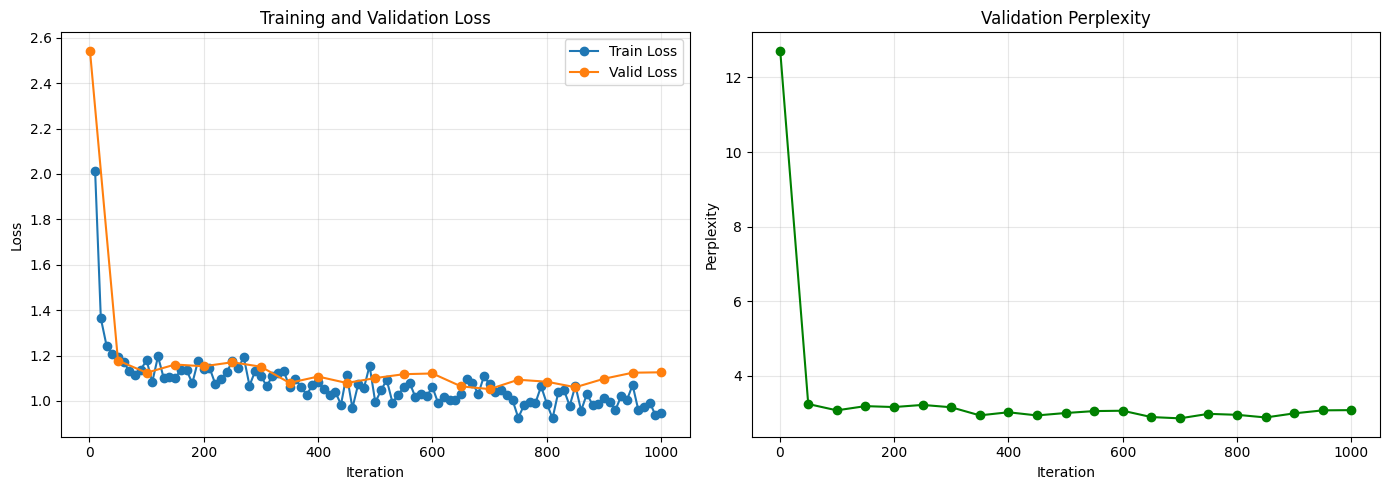


Final validation loss: 1.1261
Final perplexity: 3.08
Best validation loss: 1.0521


In [38]:
# Use the enhanced plotting method from metrics
metrics.plot_metrics()

# Print final metrics summary
if metrics.val_losses:
    final_val_loss = metrics.val_losses[-1][1]
    final_perplexity = np.exp(final_val_loss)
    print(f"\nFinal validation loss: {final_val_loss:.4f}")
    print(f"Final perplexity: {final_perplexity:.2f}")
    print(f"Best validation loss: {metrics.best_val_loss:.4f}")

### Vibes check

In [39]:
base_model, base_tokenizer = load(base_model_path)

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 175324.60it/s]


In [48]:
# Use proper Phi-3 format for generation
prompt = (
    f"<|system|>\n{SYSTEM_PROMPT}<|end|>\n"
    "<|user|>\nWhy is boxing good for you?<|end|>\n"
    "<|assistant|>"
)

base_model_answer = generate(base_model, base_tokenizer, prompt, max_tokens=200)
print(fill(base_model_answer, width=120))

Boxing is a great form of exercise for several reasons. Here are some of the benefits of boxing:  1. Cardiovascular
fitness: Boxing is a high-intensity workout that gets your heart pumping and improves your cardiovascular health. It
helps to increase your stamina, endurance, and overall fitness level.  2. Strength and muscle tone: Boxing involves a
combination of punching, footwork, and defensive movements that engage multiple muscle groups. This helps to build
strength, tone your muscles, and improve your overall body composition.  3. Flexibility and mobility: Boxing requires a
wide range of motion, which helps to improve your flexibility and mobility. The constant movement and stretching
involved in boxing can help to prevent injuries and improve your overall physical performance.  4. Mental focus and
discipline: Boxing


In [49]:
# Use the same Phi-3 format for the fine-tuned model
prompt = (
    f"<|system|>\n{SYSTEM_PROMPT}<|end|>\n"
    "<|user|>\nWhy is boxing good for you?<|end|>\n"
    "<|assistant|>"
)

ft_model_answer = generate(model, tokenizer, prompt, max_tokens=200)
print(fill(ft_model_answer, width=120))

Boxing is an excellent way to relieve stress and improve physical fitness. It also helps me develop mental toughness,
discipline, and focus, which are essential qualities for a startup founder. By pushing myself to the limit in the ring,
I've learned to adapt and overcome challenges in my personal and professional life.<|end|>


### Evaluate

The training and validation loss are only part of the story.

Let's see how good is the model trying to produce answers the same way Didier would.

In [50]:
# Parse test set to extract questions and answers
# Need to handle the system prompt in the format
test_set_questions = []
test_set_answers = []

for sample in test_set:
    # Split by assistant tag to separate prompt from answer
    if "<|assistant|>" in sample:
        parts = sample.split("<|assistant|>")
        prompt_part = parts[0] + "<|assistant|>"  # Include the assistant tag
        answer_part = parts[1] if len(parts) > 1 else ""
        
        # Remove the closing <|end|> from answer
        if "<|end|>" in answer_part:
            answer_part = answer_part.replace("<|end|>", "").strip()
        
        test_set_questions.append(prompt_part)
        test_set_answers.append(answer_part)

print(f"Extracted {len(test_set_questions)} test questions")
print(f"\nSample question format:\n{test_set_questions[0][:200]}...")
print(f"\nSample answer:\n{test_set_answers[0][:100]}...")

Extracted 255 test questions

Sample question format:
<|system|>
You are Didier, CEO of OpenBB. You write with clarity and impact, focusing on fintech, open source, AI, and the future of research workflows.<|end|>
<|user|>
Why is it essential for firms t...

Sample answer:
Firms need to be able to adopt AI at their own pace because forcing a one-size-fits-all approach can...


### Use Llama 3.2 through Ollama for evaluation purposes

In [52]:
def evaluate_with_bertscore(test_set_questions, test_set_answers, model, tokenizer):
    """
    Evaluate model using BERTScore for semantic similarity.
    BERTScore computes similarity using contextual embeddings.
    """
    global load_metric
    
    if load_metric is None:
        print("Installing evaluation libraries...")
        !pip install evaluate bert-score
        from evaluate import load as load_metric
    
    bertscore = load_metric("bertscore")
    
    predictions = []
    references = []
    
    print("Generating predictions for test set...")
    for prompt, ground_truth in tqdm(zip(test_set_questions, test_set_answers), 
                                     total=len(test_set_questions)):
        # Generate response from fine-tuned model
        response = generate(model, tokenizer, prompt, max_tokens=200)
        
        # Extract just the answer part (remove special tokens)
        if "<|assistant|>" in response:
            response = response.split("<|assistant|>")[-1]
        if "<|end|>" in response:
            response = response.split("<|end|>")[0]
            
        # Clean ground truth
        clean_truth = ground_truth.strip()
        
        predictions.append(response.strip())
        references.append(clean_truth)
    
    # Compute BERTScore
    print("\nComputing BERTScore metrics...")
    results = bertscore.compute(
        predictions=predictions, 
        references=references,
        lang="en",
        model_type="microsoft/deberta-xlarge-mnli",  # Good model for semantic similarity
        verbose=False
    )
    
    # Extract scores
    precision_scores = results['precision']
    recall_scores = results['recall']
    f1_scores = results['f1']
    
    return {
        'precision_scores': precision_scores,
        'recall_scores': recall_scores,
        'f1_scores': f1_scores,
        'predictions': predictions,
        'references': references
    }

def evaluate_with_simple_metrics(test_set_questions, test_set_answers, model, tokenizer):
    """
    Fallback evaluation using simpler metrics if BERTScore is too slow.
    Uses word overlap for semantic similarity approximation.
    """
    predictions = []
    references = []
    exact_matches = []
    
    print("Generating predictions for test set...")
    for prompt, ground_truth in tqdm(zip(test_set_questions, test_set_answers), 
                                     total=len(test_set_questions)):
        # Generate response
        response = generate(model, tokenizer, prompt, max_tokens=200)
        
        # Clean responses
        if "<|assistant|>" in response:
            response = response.split("<|assistant|>")[-1]
        if "<|end|>" in response:
            response = response.split("<|end|>")[0]
            
        clean_truth = ground_truth.strip()
        clean_response = response.strip()
        
        predictions.append(clean_response)
        references.append(clean_truth)
        
        # Check for semantic similarity (simple heuristic)
        truth_words = set(re.findall(r'\w+', clean_truth.lower()))
        response_words = set(re.findall(r'\w+', clean_response.lower()))
        
        if truth_words and response_words:
            overlap = len(truth_words & response_words) / len(truth_words | response_words)
            exact_matches.append(overlap)
        else:
            exact_matches.append(0.0)
    
    return {
        'word_overlap_scores': exact_matches,
        'predictions': predictions,
        'references': references
    }

# Choose evaluation method based on your needs
# BERTScore is more accurate but slower
USE_BERTSCORE = False  # Set to False for faster evaluation

if USE_BERTSCORE:
    print("Using BERTScore for evaluation (more accurate, slower)")
    eval_results = evaluate_with_bertscore(test_set_questions, test_set_answers, model, tokenizer)
    scores = eval_results['f1_scores']
    metric_name = "BERTScore F1"
else:
    print("Using simple metrics for evaluation (less accurate, faster)")
    eval_results = evaluate_with_simple_metrics(test_set_questions, test_set_answers, model, tokenizer)
    scores = eval_results['word_overlap_scores']
    metric_name = "Word Overlap"

# Display first 5 scores
print(f"\nFirst 5 {metric_name} scores:", scores[:5])

Using simple metrics for evaluation (less accurate, faster)
Generating predictions for test set...


  0%|          | 0/255 [00:00<?, ?it/s]

100%|██████████| 255/255 [08:53<00:00,  2.09s/it]


First 5 Word Overlap scores: [0.2823529411764706, 0.3492063492063492, 0.1702127659574468, 0.16883116883116883, 0.21686746987951808]


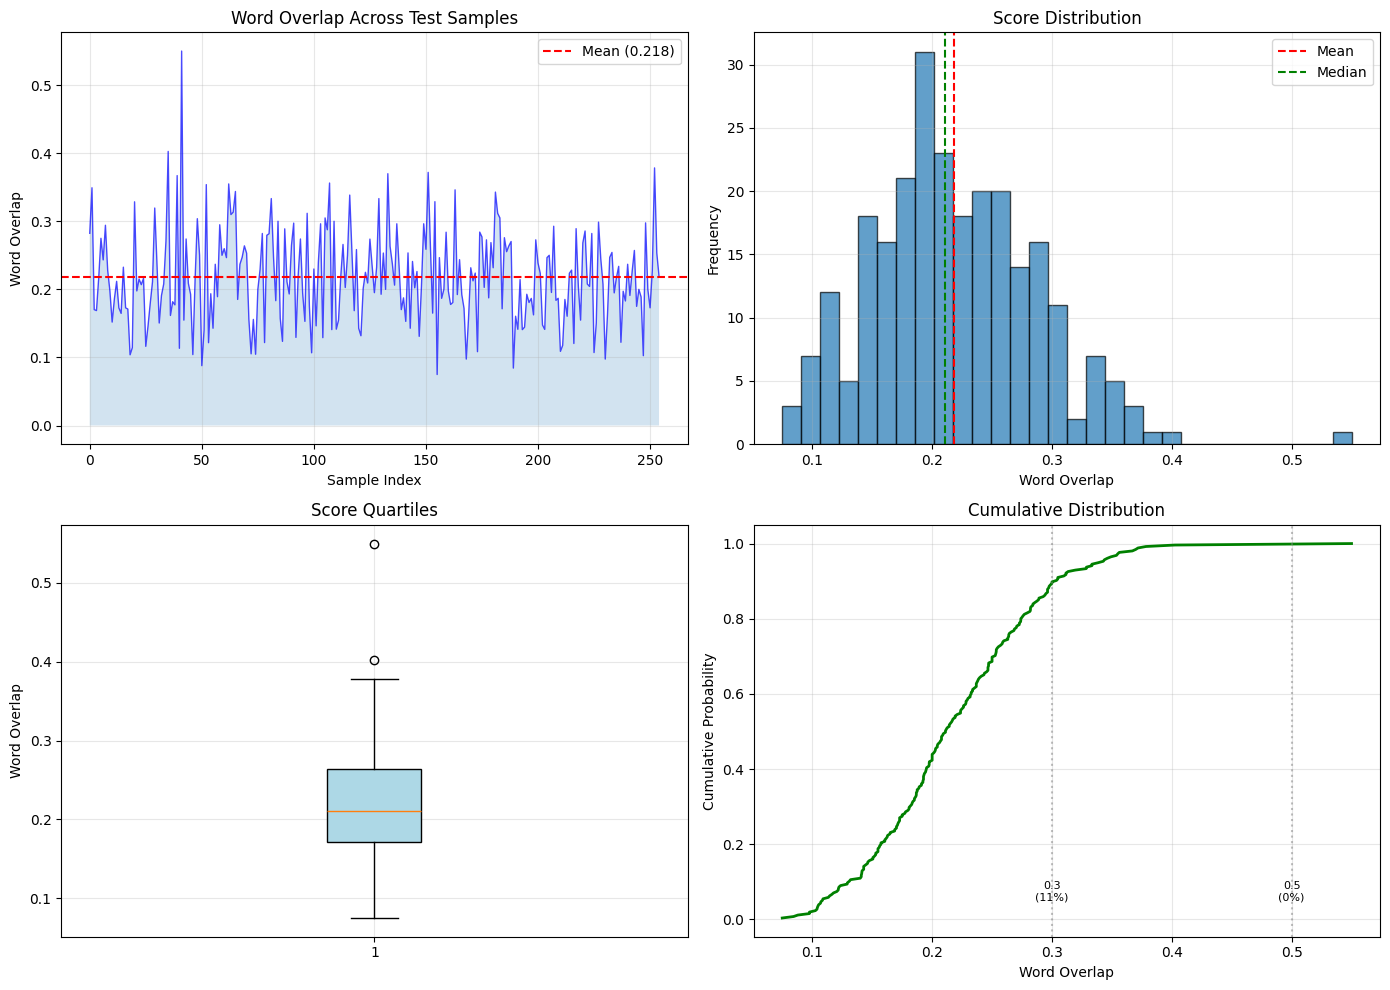


Detailed Statistics for Word Overlap

📊 Central Tendency & Spread:
  Mean:     0.2184
  Median:   0.2111
  Std Dev:  0.0690
  Range:    [0.0749, 0.5500]

📈 Quartile Analysis:
  Q1 (25%): 0.1712
  Q3 (75%): 0.2635
  IQR:      0.0923

🎯 Performance Breakdown:
  Excellent (≥0.9): 0.0%
  Good (≥0.7):      0.0%
  Acceptable (≥0.5): 0.4%
  Poor (≤0.3):      89.8%


In [53]:
def plot_and_analyze_scores(scores, metric_name="Similarity Score"):
    """Enhanced plotting with better statistics and visualization"""
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Line plot of scores
    ax1 = axes[0, 0]
    ax1.plot(range(len(scores)), scores, 'b-', alpha=0.7, linewidth=1)
    ax1.fill_between(range(len(scores)), scores, alpha=0.2)
    mean_score = np.mean(scores)
    ax1.axhline(y=mean_score, color='r', linestyle='--', label=f'Mean ({mean_score:.3f})')
    ax1.set_xlabel('Sample Index')
    ax1.set_ylabel(metric_name)
    ax1.set_title(f'{metric_name} Across Test Samples')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Histogram of score distribution
    ax2 = axes[0, 1]
    ax2.hist(scores, bins=30, edgecolor='black', alpha=0.7)
    ax2.axvline(x=mean_score, color='r', linestyle='--', label=f'Mean')
    ax2.axvline(x=np.median(scores), color='g', linestyle='--', label=f'Median')
    ax2.set_xlabel(metric_name)
    ax2.set_ylabel('Frequency')
    ax2.set_title('Score Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Box plot for quartile analysis
    ax3 = axes[1, 0]
    box = ax3.boxplot(scores, vert=True, patch_artist=True)
    box['boxes'][0].set_facecolor('lightblue')
    ax3.set_ylabel(metric_name)
    ax3.set_title('Score Quartiles')
    ax3.grid(True, alpha=0.3)
    
    # 4. Cumulative distribution
    ax4 = axes[1, 1]
    sorted_scores = np.sort(scores)
    cumulative = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores)
    ax4.plot(sorted_scores, cumulative, 'g-', linewidth=2)
    ax4.set_xlabel(metric_name)
    ax4.set_ylabel('Cumulative Probability')
    ax4.set_title('Cumulative Distribution')
    ax4.grid(True, alpha=0.3)
    
    # Add threshold lines for reference
    thresholds = [0.3, 0.5, 0.7, 0.9]
    for thresh in thresholds:
        if min(scores) <= thresh <= max(scores):
            pct = np.mean(np.array(scores) >= thresh) * 100
            ax4.axvline(x=thresh, color='gray', linestyle=':', alpha=0.5)
            ax4.text(thresh, 0.05, f'{thresh:.1f}\n({pct:.0f}%)', 
                    ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate comprehensive statistics
    stats = {
        'Mean': np.mean(scores),
        'Median': np.median(scores),
        'Std Dev': np.std(scores),
        'Min': np.min(scores),
        'Max': np.max(scores),
        'Q1 (25%)': np.percentile(scores, 25),
        'Q3 (75%)': np.percentile(scores, 75),
        'IQR': np.percentile(scores, 75) - np.percentile(scores, 25),
        'Scores ≥ 0.9': np.mean(np.array(scores) >= 0.9),  # Excellent matches
        'Scores ≥ 0.7': np.mean(np.array(scores) >= 0.7),  # Good matches
        'Scores ≥ 0.5': np.mean(np.array(scores) >= 0.5),  # Acceptable matches
        'Scores ≤ 0.3': np.mean(np.array(scores) <= 0.3),  # Poor matches
    }
    
    # Print detailed statistics
    print(f"\n{'='*50}")
    print(f"Detailed Statistics for {metric_name}")
    print(f"{'='*50}")
    
    print("\n📊 Central Tendency & Spread:")
    print(f"  Mean:     {stats['Mean']:.4f}")
    print(f"  Median:   {stats['Median']:.4f}")
    print(f"  Std Dev:  {stats['Std Dev']:.4f}")
    print(f"  Range:    [{stats['Min']:.4f}, {stats['Max']:.4f}]")
    
    print("\n📈 Quartile Analysis:")
    print(f"  Q1 (25%): {stats['Q1 (25%)']:.4f}")
    print(f"  Q3 (75%): {stats['Q3 (75%)']:.4f}")
    print(f"  IQR:      {stats['IQR']:.4f}")
    
    print("\n🎯 Performance Breakdown:")
    print(f"  Excellent (≥0.9): {stats['Scores ≥ 0.9']:.1%}")
    print(f"  Good (≥0.7):      {stats['Scores ≥ 0.7']:.1%}")
    print(f"  Acceptable (≥0.5): {stats['Scores ≥ 0.5']:.1%}")
    print(f"  Poor (≤0.3):      {stats['Scores ≤ 0.3']:.1%}")
    
    return stats

# Use the function with the evaluation results
stats = plot_and_analyze_scores(scores, metric_name)

### Compare against benchmark model

Evaluating BASE MODEL for comparison


Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 212992.00it/s]


Generating predictions for test set...


100%|██████████| 255/255 [19:20<00:00,  4.55s/it]


🔵 BASE MODEL PERFORMANCE:


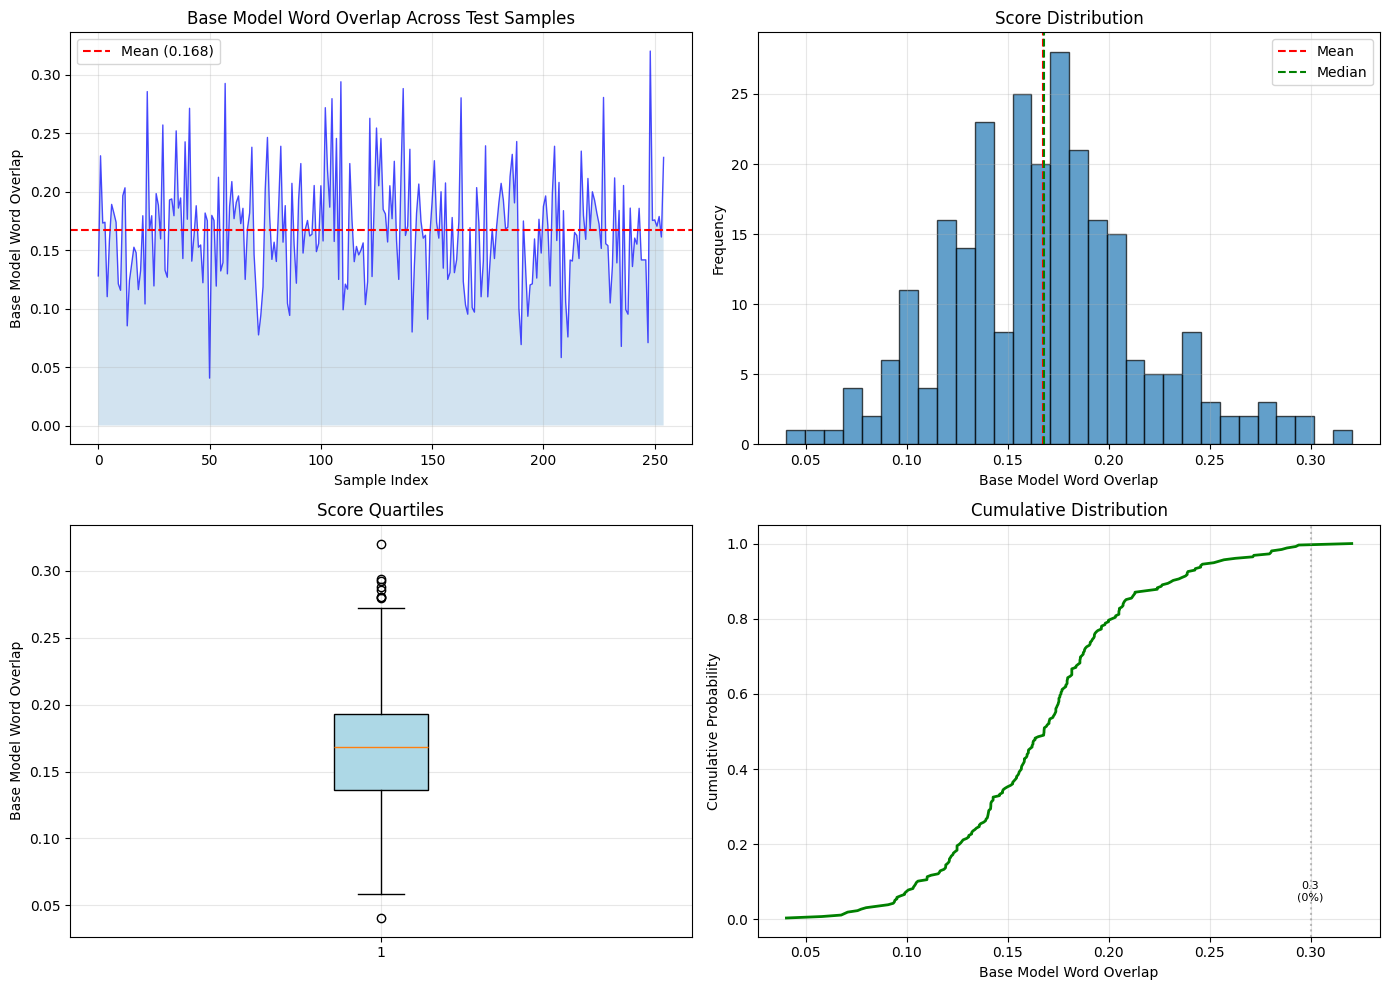


Detailed Statistics for Base Model Word Overlap

📊 Central Tendency & Spread:
  Mean:     0.1677
  Median:   0.1681
  Std Dev:  0.0476
  Range:    [0.0405, 0.3204]

📈 Quartile Analysis:
  Q1 (25%): 0.1363
  Q3 (75%): 0.1928
  IQR:      0.0565

🎯 Performance Breakdown:
  Excellent (≥0.9): 0.0%
  Good (≥0.7):      0.0%
  Acceptable (≥0.5): 0.0%
  Poor (≤0.3):      99.6%

📊 PERFORMANCE COMPARISON: Fine-tuned vs Base Model

🎯 Mean Score:
  Base Model:  0.1677
  Fine-tuned:  0.2184
  Improvement: +30.3%

📈 Good Matches (≥0.7):
  Base Model:  0.0%
  Fine-tuned:  0.0%

📉 Poor Matches (≤0.3):
  Base Model:  99.6%
  Fine-tuned:  89.8%


In [55]:
# Compare against base model (before fine-tuning)
print("="*60)
print("Evaluating BASE MODEL for comparison")
print("="*60)

model_path = "microsoft/Phi-3-mini-4k-instruct"
base_model, base_tokenizer = load(model_path)

# Use the same evaluation method for fair comparison
if USE_BERTSCORE:
    base_eval_results = evaluate_with_bertscore(test_set_questions, test_set_answers, base_model, base_tokenizer)
    base_scores = base_eval_results['f1_scores']
else:
    base_eval_results = evaluate_with_simple_metrics(test_set_questions, test_set_answers, base_model, base_tokenizer)
    base_scores = base_eval_results['word_overlap_scores']

# Plot base model results
print("\n🔵 BASE MODEL PERFORMANCE:")
base_stats = plot_and_analyze_scores(base_scores, f"Base Model {metric_name}")

# Compare the two models
print("\n" + "="*60)
print("📊 PERFORMANCE COMPARISON: Fine-tuned vs Base Model")
print("="*60)

improvement = ((stats['Mean'] - base_stats['Mean']) / base_stats['Mean']) * 100
print(f"\n🎯 Mean Score:")
print(f"  Base Model:  {base_stats['Mean']:.4f}")
print(f"  Fine-tuned:  {stats['Mean']:.4f}")
print(f"  Improvement: {improvement:+.1f}%")

print(f"\n📈 Good Matches (≥0.7):")
print(f"  Base Model:  {base_stats['Scores ≥ 0.7']:.1%}")
print(f"  Fine-tuned:  {stats['Scores ≥ 0.7']:.1%}")

print(f"\n📉 Poor Matches (≤0.3):")
print(f"  Base Model:  {base_stats['Scores ≤ 0.3']:.1%}")
print(f"  Fine-tuned:  {stats['Scores ≤ 0.3']:.1%}")

### Fuse Adapters

Sometimes its convenient to fuse the adapters into the base model to create a single adapted model.

MLX LM has a fuse script just for that.

The adapted weights are: $\tilde{W} = W + c \cdot \mathbf{b}^\top \mathbf{a}$. Note, this process can be destructive if the inputs are in low precision and they have very different magnitudes. Tuning the `scale` parameter, $c$, prior to fine-tuning can improve the model performance after fusion.

To see more options for fusing the model, including how to upload to HuggingFace [check the documentation](https://github.com/ml-explore/mlx-examples/blob/main/llms/mlx_lm/LORA.md#fuse).

In [56]:
import os
# Disable parallelism to prevent issues with the tokenizer
os.environ["TOKENIZERS_PARALLELISM"] = "false"

!mlx_lm.fuse --model {model_path} --adapter-path adapters --save-path lora_fused_model

python(77404) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Loading pretrained model
Fetching 13 files: 100%|████████████████████| 13/13 [00:00<00:00, 119312.81it/s]


Once the adapters are fused, we can rerun the evaluation using the fused model to make sure it worked.

Evaluating FUSED MODEL to verify fusion
Generating predictions for test set...


100%|██████████| 255/255 [09:06<00:00,  2.14s/it]



🟢 FUSED MODEL PERFORMANCE:


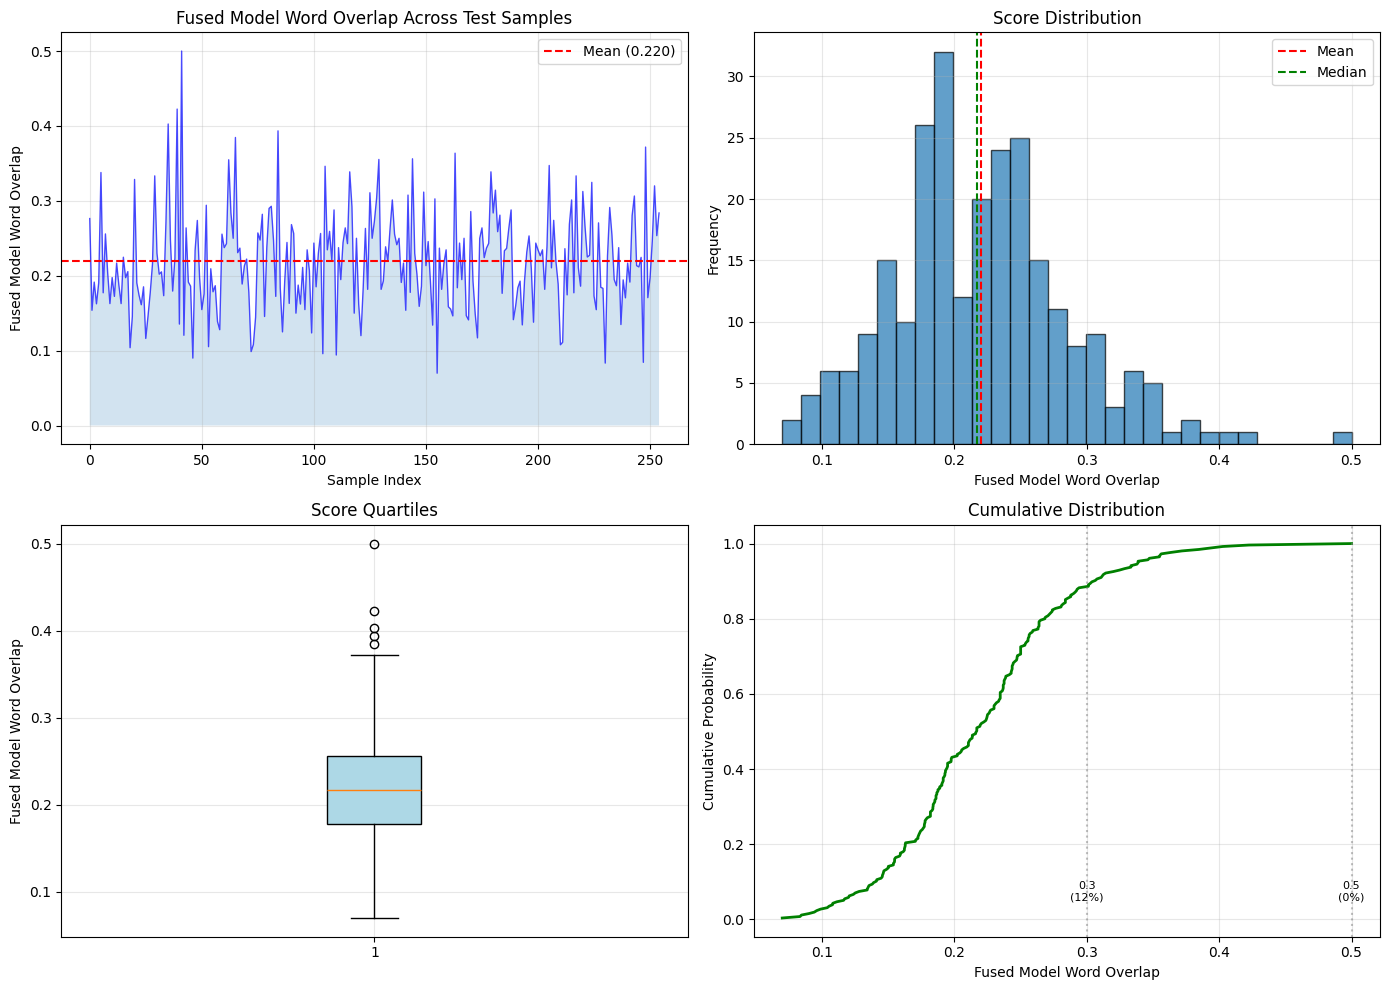


Detailed Statistics for Fused Model Word Overlap

📊 Central Tendency & Spread:
  Mean:     0.2200
  Median:   0.2169
  Std Dev:  0.0669
  Range:    [0.0699, 0.5000]

📈 Quartile Analysis:
  Q1 (25%): 0.1773
  Q3 (75%): 0.2561
  IQR:      0.0788

🎯 Performance Breakdown:
  Excellent (≥0.9): 0.0%
  Good (≥0.7):      0.0%
  Acceptable (≥0.5): 0.4%
  Poor (≤0.3):      88.2%

✅ FUSION VERIFICATION
✓ Fusion successful! Score difference: 0.0016
  Fine-tuned mean: 0.2184
  Fused mean:      0.2200


In [57]:
# Evaluate the fused model to ensure fusion worked correctly
print("="*60)
print("Evaluating FUSED MODEL to verify fusion")
print("="*60)

fused_model, fused_tokenizer = load("lora_fused_model")

# Use the same evaluation method
if USE_BERTSCORE:
    fused_eval_results = evaluate_with_bertscore(test_set_questions, test_set_answers, fused_model, fused_tokenizer)
    fused_scores = fused_eval_results['f1_scores']
else:
    fused_eval_results = evaluate_with_simple_metrics(test_set_questions, test_set_answers, fused_model, fused_tokenizer)
    fused_scores = fused_eval_results['word_overlap_scores']

# Plot fused model results
print("\n🟢 FUSED MODEL PERFORMANCE:")
fused_stats = plot_and_analyze_scores(fused_scores, f"Fused Model {metric_name}")

# Verify fusion worked correctly
print("\n" + "="*60)
print("✅ FUSION VERIFICATION")
print("="*60)

score_diff = abs(stats['Mean'] - fused_stats['Mean'])
if score_diff < 0.01:  # Within 1% difference
    print(f"✓ Fusion successful! Score difference: {score_diff:.4f}")
    print(f"  Fine-tuned mean: {stats['Mean']:.4f}")
    print(f"  Fused mean:      {fused_stats['Mean']:.4f}")
else:
    print(f"⚠️  Warning: Significant difference detected!")
    print(f"  Fine-tuned mean: {stats['Mean']:.4f}")
    print(f"  Fused mean:      {fused_stats['Mean']:.4f}")
    print(f"  Difference:      {score_diff:.4f}")
    print("\nConsider adjusting the LoRA scale parameter before fusion.")

### Push model to hugging face

In [ ]:
# Define the model and dataset repository names
model_repo = "didierlopes/phi-3-mini-4k-instruct-ft-on-didier-blog"

# First save the model locally with all necessary files
save_directory = "lora_fused_model"

# Ensure the model files are properly saved in the directory
# The files should already be there from the previous fuse step

# # Initialize the Hugging Face API
# api = HfApi()

# # Create the model repository
# api.create_repo(
#     repo_id=model_repo,
#     private=False,
#     exist_ok=True,
#     token=os.getenv('HF_TOKEN')
# )

# # Upload the entire directory
# api.upload_folder(
#     folder_path=save_directory,
#     repo_id=model_repo,
#     token=os.getenv('HF_TOKEN')
# )

print(f"Model ready to push to: https://huggingface.co/{model_repo}")

In [ ]:
# Example usage of the fine-tuned model
print("="*60)
print("TESTING FINE-TUNED MODEL")
print("="*60)

# Load the fused model for inference
inference_model, inference_tokenizer = load("lora_fused_model")

# System prompt for consistency
SYSTEM_PROMPT = "You are a helpful AI assistant with expertise in finance and open-source software."

# Test questions
test_questions = [
    "Why is OpenBB special?",
    "What makes Gamestonk Terminal unique?",
    "How can the community contribute to the project?",
    "What are the main features of the terminal?",
]

print("\n🤖 Fine-tuned Model Responses:\n")
for question in test_questions:
    # Use proper Phi-3 format
    prompt = (
        f"<|system|>\n{SYSTEM_PROMPT}<|end|>\n"
        f"<|user|>\n{question}<|end|>\n"
        f"<|assistant|>"
    )
    
    response = safe_generate(
        inference_model, 
        inference_tokenizer, 
        prompt, 
        max_tokens=150,
        temperature=0.7
    )
    
    # Clean up the response
    if "<|assistant|>" in response:
        response = response.split("<|assistant|>")[-1]
    if "<|end|>" in response:
        response = response.split("<|end|>")[0]
    
    print(f"Q: {question}")
    print(f"A: {response.strip()}")
    print("-" * 40)

### Using the Fine-tuned Model

Now let's test the fine-tuned model with some example questions to see how it responds in the style of the training data:

### Troubleshooting

#### Results

To figure out why your LoRA adapters are not working well it's critical to plot both the trianing loss and validation loss over the duration of fine-tuning. There are really only two cases to consider: underfitting or overfitting. And you can figure out which regime you are in based on the above plot.

**Underfitting**: The trianing loss is not low enough and the validation loss closely matches the training loss. You could also measure the accuracy on the training set itself for question-answering style tasks like HellaSwag. If you are in this regime you have a few options to improve the results:

- Use more adapters. Increase `lora_layers` or adapt more of the linear layers within a given block by setting `lora_parameters["keys"]`.
- Use a higher rank. A higher rank means more parameters per adapter.
- If you are using dropout, decrease the droupout rate or turn it off entirely.
- Sometimes, underfitting issues are really optimization issues. In these cases it can be helpful to tune the learning rate or learning rate schedule.
- If none of the above works, try a bigger model. For example, try Phi-3 medium instead of Phi-3 tiny.

**Overfitting**: The trianing loss keeps going down but the validation loss stops going down and even starts to go up. If you are in this regime you also have a few options:

- The best thing to do is to use more trianing data if you have it.
- Contrary to the underfitting regime decreasing the capacity of the model can help. For example, use fewer adapters, a lower LoRA rank, or a smaller model size.
- If you are not using dropout, use it.

If you find your adapters work well pre-fusion but stop working post-fusion, try tuning the `scale` parameter, $c$, prior to fine-tuning. Typically the adapters have a smaller magnitude than the weights, so using a larger scale helps.

#### Memory Use

Fine-tuning a large LM with LoRA requires a machine with a decent amount of memory. Here are some tips to reduce memory use should you need to do so. 

- Try quantization (QLoRA). You can use QLoRA by generating a quantized model with `mlx_lm.convert` and the `-q` flag or by using an already quantized model from HuggingFace.

- Try using a smaller batch size. You can set the `batch_size` parameter in the `TrainingArgs` or pass `--batch-size` if you are using the CLI. The default is 4 so setting this to 2 or 1 will reduce memory consumption. Note, this may slow things down a little..

- Reduce the number of layers to fine-tune with by setting `lora_layers` to a smaller value or passing `--lora-layers` if you are using the CLI. The default is `16`, so you can try `8` or `4`. This reduces the amount of memory needed for back propagation. It may also reduce the quality of the fine-tuned model and you may need to compensate with a larger `rank`.

- Longer examples require more memory. If it makes sense for your data, one thing you can do is break your examples into smaller sequences when making the `train`, `valid`, and `test` data sets.

- Gradient checkpointing lets you trade-off memory use (less) for computation (more) by recomputing instead of storing intermediate values needed by the backward pass. You can use gradient checkpointing by passing `grad_checkpoint=True` to the `TrainingArgs` or the `--grad-checkpoint` flag if using the CLI. Gradient checkpointing will be more helpful for larger batch sizes or sequence lengths with smaller or quantized models.

### Next Steps

- To learn more about MLX check-out the [GitHub repo](http://github.com/ml-explore/mlx) and [documentation](https://ml-explore.github.io/mlx/)
- For more on MLX LM check-out the [MLX LM documentation](https://github.com/ml-explore/mlx-examples/tree/main/llms#readme).
- Check out the other [MLX Examples](https://github.com/ml-explore/mlx-examples/tree/main). These are great as a learning resource or to use as a starting point for a new project.
- We also have an example of [LoRA fine-tuning in MLX Swift](https://github.com/ml-explore/mlx-swift-examples/tree/main/Applications/LoRATrainingExample).